In [8]:
# =========================
# CELL 1 — Config & Paths (judge-friendly + reproducible)
# - No hard-coded absolute paths
# - Works whether you run notebook from repo root or from notebooks/
# - DOES NOT copy data anywhere (judge-friendly)
# - Uses pathlib for cross-platform paths
# =========================

import os, re, json, math
from datetime import datetime, timezone
from typing import Dict, Any, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# Reproducibility seed
# -------------------------
SEED = int(os.environ.get("SEED", "42"))
np.random.seed(SEED)

# -------------------------
# Paths (robust for Jupyter)
# -------------------------
from pathlib import Path

def _find_repo_root(start: Path) -> Path:
    """
    Find project root by walking up until a folder containing 'notebooks' is found.
    Fallback: use current working dir.
    """
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / "notebooks").exists():
            return p
    return start

# In Jupyter, __file__ may not exist. Use cwd.
CWD = Path.cwd().resolve()
REPO_ROOT = _find_repo_root(CWD)

# If notebook is in notebooks/, keep NOTEBOOKS_DIR = REPO_ROOT/notebooks
NOTEBOOKS_DIR = (REPO_ROOT / "notebooks").resolve()

# Data/outputs location:
# - Prefer notebooks/data if exists
# - Else fallback to repo_root/data
DATA_DIR = (NOTEBOOKS_DIR / "data") if (NOTEBOOKS_DIR / "data").exists() else (REPO_ROOT / "data")

# Outputs always under notebooks/outputs to match your current structure
OUT_DIR = NOTEBOOKS_DIR / "outputs"
OUT_02 = OUT_DIR / "02_eda"
OUT_03 = OUT_DIR / "03_features"
OUT_04 = OUT_DIR / "04_models"
OUT_04P = OUT_04 / "predictions"
OUT_05 = OUT_DIR / "05_scaling"

for p in [OUT_02, OUT_03, OUT_04, OUT_04P, OUT_05]:
    p.mkdir(parents=True, exist_ok=True)

# Provide string paths if later cells use os.path.join / strings
PROJECT_ROOT = str(NOTEBOOKS_DIR)  # keep compatible with later cells that expect PROJECT_ROOT as string

print("✅ Paths resolved:")
print(" - REPO_ROOT     :", REPO_ROOT)
print(" - NOTEBOOKS_DIR :", NOTEBOOKS_DIR)
print(" - DATA_DIR      :", DATA_DIR)
print(" - OUT_DIR       :", OUT_DIR)

# -------------------------
# Core helpers (keep as-is for other cells)
# -------------------------
def tag_minutes(tag: str) -> int:
    return {"1m": 1, "5m": 5, "15m": 15}[tag]

def steps_per_day(tag: str) -> int:
    return int(24 * 60 / tag_minutes(tag))

def steps_per_hour(tag: str) -> int:
    return int(60 / tag_minutes(tag))

def resolve_roll_windows(tag: str, roll_windows: List[str]) -> Dict[str, int]:
    sph = steps_per_hour(tag)
    spd = steps_per_day(tag)
    out = {}
    for w in roll_windows:
        if w == "1h":
            out[w] = 1 * sph
        elif w == "6h":
            out[w] = 6 * sph
        elif w == "1d":
            out[w] = 1 * spd
        else:
            raise ValueError(f"Unsupported roll window: {w}")
    return out

# -------------------------
# CFG (one source of truth)
# -------------------------
CFG: Dict[str, Any] = {
    # ===== Dataset =====
    # Prefer access_log.txt in DATA_DIR; judge just needs to put data in ./data or ./notebooks/data
    "RAW_LOG_PATH": str(DATA_DIR / "access_log.txt"),
    "TAGS": ["1m", "5m", "15m"],
    "TIME_COL_RAW": "timestamp",
    "TIME_COL_BUCKET": "bucket_start",

    # Storm gap (problem statement)
    "STORM_START": pd.Timestamp("1995-08-01 14:52:01"),
    "STORM_END":   pd.Timestamp("1995-08-03 04:36:13"),

    # ===== Feature engineering =====
    "LAG_DAYS": [1,2,3,4,5,6,7],
    "ROLL_WINDOWS": ["1h","6h","1d"],
    "ROLL_USE_STD": True,
    "USE_CYCLIC": True,
    "HORIZON_STEPS": 1,
    "KEEP_RAW_EXTRA": [
        "unique_hosts","err_4xx","err_5xx","error_rate",
        "is_missing_bucket","is_gap_storm","is_gap_unknown"
    ],
    "REQUIRE_COLS": ["bucket_start","hits","bytes_sum","is_gap"],

    # ===== Modeling =====
    "TARGETS": ["hits", "bytes_sum"],
    "XGB_PARAMS": dict(
        booster="gbtree",
        n_estimators=5000,
        early_stopping_rounds=50,
        objective="reg:squarederror",
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=SEED,
    ),
    "CV_SPLITS": 5,
    "CV_TEST_DAYS": 2,
    "CV_GAP_STEPS": 1,

    # ==========================================================
    # AUTOSCALING / SIMULATION CONFIG (Window-aware + Metric-aware)
    # ==========================================================
    "SCALING": {
        "min_instances": 2,
        "max_instances": 50,
        "cost_per_instance_per_hour": 0.05,
        "window_minutes": {"1m": 1, "5m": 5, "15m": 15},
        "safety_buffer_by_metric": {"hits": 0.3, "bytes_sum": 0.3},
        "capacity_per_instance": {
            ("hits","1m"): 20, ("hits","5m"): 100, ("hits","15m"): 350,
            ("bytes_sum","1m"): 350_000, ("bytes_sum","5m"): 1_200_000, ("bytes_sum","15m"): 3_500_000,
        },
        "max_step_change_by_window": {"1m": 6, "5m": 10, "15m": 15},
        "hysteresis_by_window": {
            "1m": {"high": 2, "low": 6, "in_margin": 0.18},
            "5m": {"high": 1, "low": 4, "in_margin": 0.15},
            "15m":{"high": 1, "low": 2, "in_margin": 0.12},
        },
        "predictive_deadband_by_window": {"1m": 0.5, "5m": 0.5, "15m": 0.5},
        "cooldown_minutes": {"base": 8, "spike": 15},
        "provisioning_by_window": {
            "1m": {"warmup_windows": 1, "min_uptime_windows": 6},
            "5m": {"warmup_windows": 1, "min_uptime_windows": 4},
            "15m":{"warmup_windows": 0, "min_uptime_windows": 2},
        },
        "reactive": {
            "enabled": True,
            "overload_scale_out_immediate": True,
            "rescue_extra_instances": 3,
            "queue_low_fraction": 0.05,
            "queue_high_multiplier": 4.0,
        },
        "slo": {
            "base_latency_ms": 80.0,
            "alpha_latency_per_unit_queue": 0.15,
            "p95_latency_target_ms": 300.0,
        },
        "anomaly": {
            "enabled": True,
            "method": "mad",
            "lookback_hours": 2,
            "mad_k": 6.0,
            "min_points": 10,
            "max_flag_rate": 0.30,
        },
        "ddos_mode": {
            "enabled": True,
            "force_scale_out_step_by_window": {"1m": 6, "5m": 10, "15m": 12},
            "max_instances_during_ddos": 50,
        },
    }
}

print("✅ Cell 1 done — CFG ready (CFG['SCALING'] exists)")


✅ Paths resolved:
 - REPO_ROOT     : C:\Users\PC\OneDrive - National Economics University\Máy tính\SC\AUTOSCALING-ANALYSIS
 - NOTEBOOKS_DIR : C:\Users\PC\OneDrive - National Economics University\Máy tính\SC\AUTOSCALING-ANALYSIS\notebooks
 - DATA_DIR      : C:\Users\PC\OneDrive - National Economics University\Máy tính\SC\AUTOSCALING-ANALYSIS\notebooks\data
 - OUT_DIR       : C:\Users\PC\OneDrive - National Economics University\Máy tính\SC\AUTOSCALING-ANALYSIS\notebooks\outputs
✅ Cell 1 done — CFG ready (CFG['SCALING'] exists)


BASE_DIR : C:\Users\PC\OneDrive - National Economics University\Máy tính\SC\AUTOSCALING-ANALYSIS\notebooks
TRAIN_DIR: C:\Users\PC\OneDrive - National Economics University\Máy tính\SC\AUTOSCALING-ANALYSIS\notebooks\data\train
TEST_DIR : C:\Users\PC\OneDrive - National Economics University\Máy tính\SC\AUTOSCALING-ANALYSIS\notebooks\data\test
OUT_DIR  : C:\Users\PC\OneDrive - National Economics University\Máy tính\SC\AUTOSCALING-ANALYSIS\notebooks\outputs\02_eda
MAIN_FREQ=5m (5min) | bucket=5 min
train: rows=15,264 after_filter=13,822 range=1995-07-01 00:00:00-04:00 -> 1995-08-22 23:55:00-04:00
test : rows=2,592 after_filter=2,592 range=1995-08-23 00:00:00-04:00 -> 1995-08-31 23:55:00-04:00

TRAIN tail-risk stats:
     label  rows  hits_mean  hits_med  hits_p95  hits_p99  hits_max   bytes_mean   bytes_p95   bytes_p99  bytes_max  err_mean  err_p95  err_max  hosts_mean  hosts_p95
 train_1m 69109  42.468145      36.0      98.0    132.00     405.0 8.245615e+05  2274347.00  3434986.40 10214823

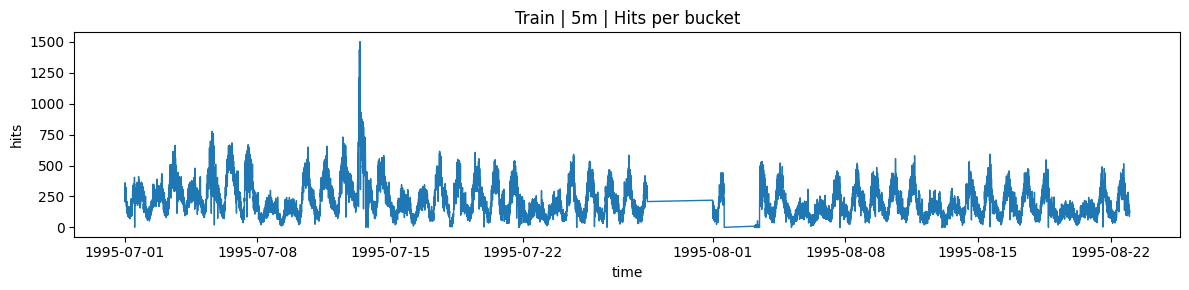

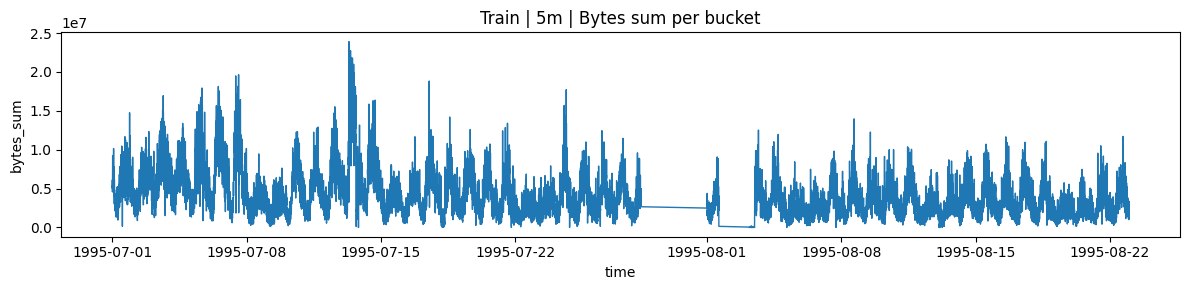

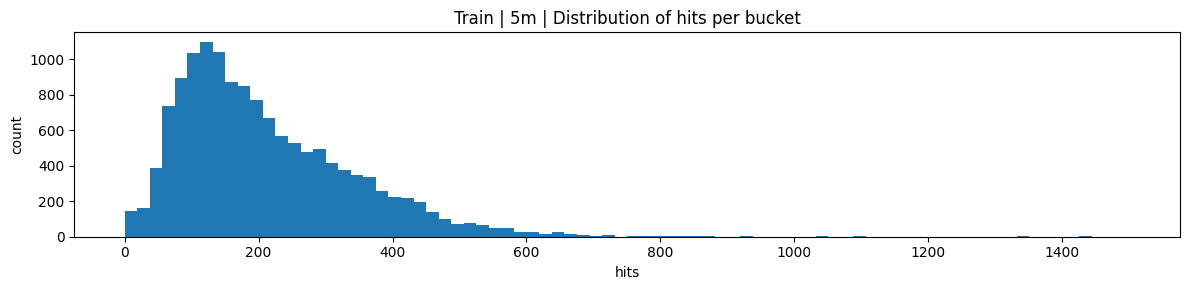

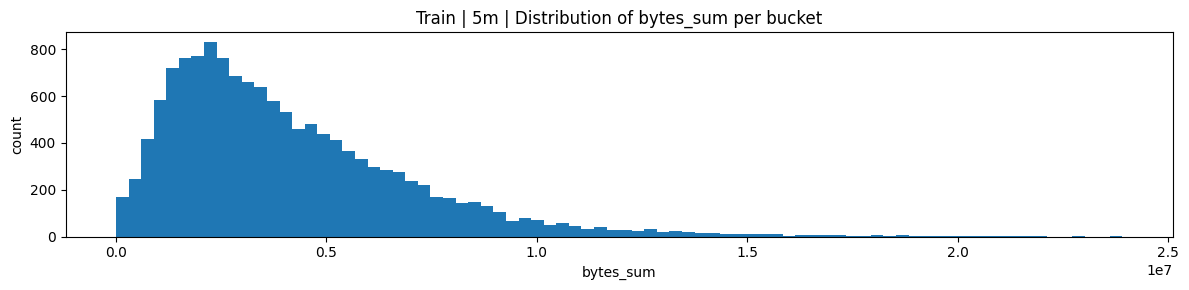

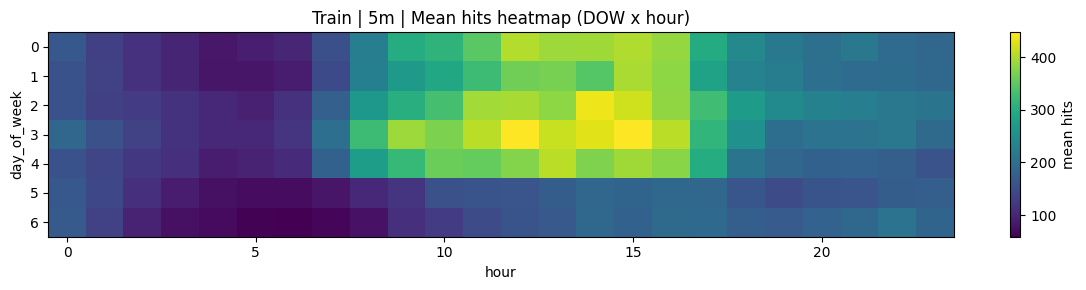

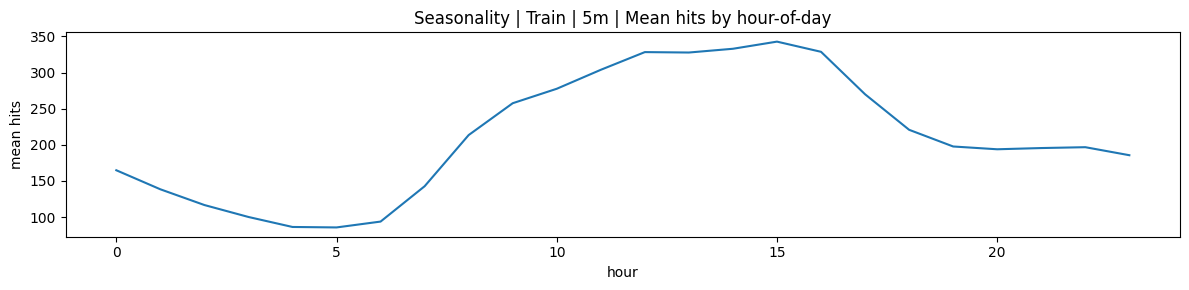

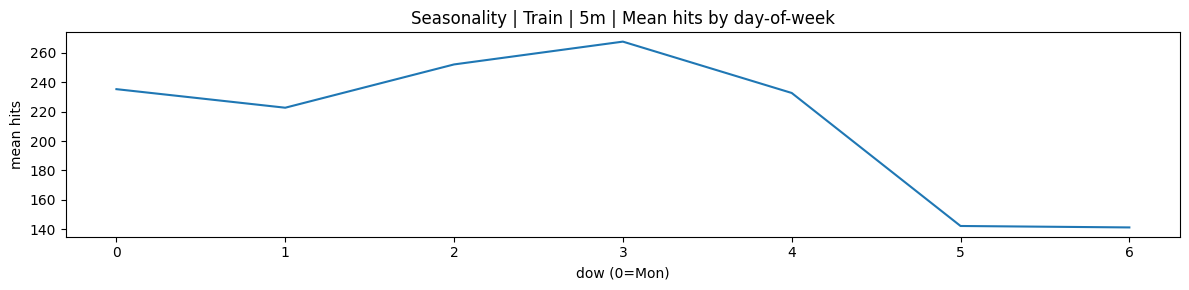


ACF peaks (hits) | 12h lag=144: -0.1318 | 24h lag=288: 0.5525


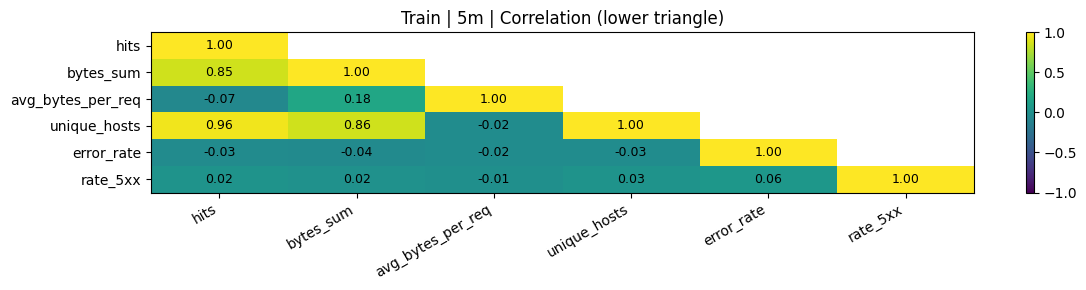

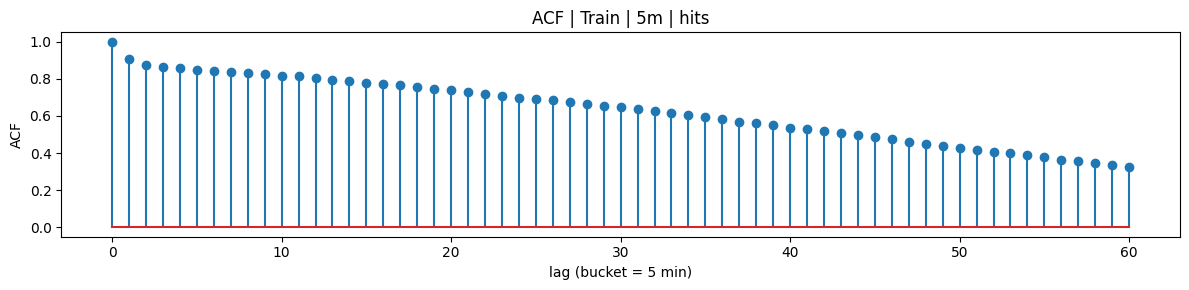

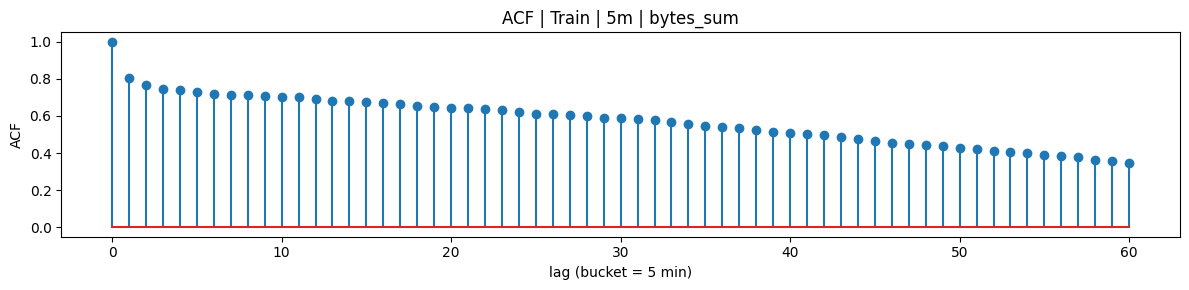


Spike type counts (train):
 spike_type
normal             13543
error_incident       139
flash_crowd          139
bandwidth_spike        1

IsolationForest | Train | 5m: anomalies=139 (1.01%)
Saved: C:\Users\PC\OneDrive - National Economics University\Máy tính\SC\AUTOSCALING-ANALYSIS\notebooks\outputs\02_eda\anomalies_isoforest_train.csv


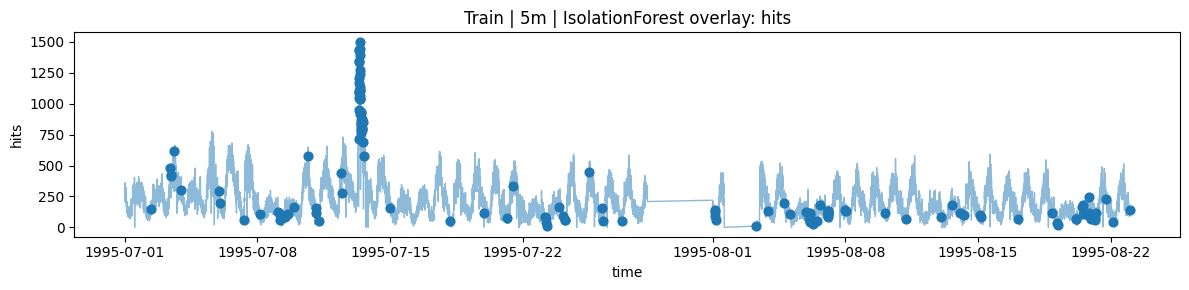

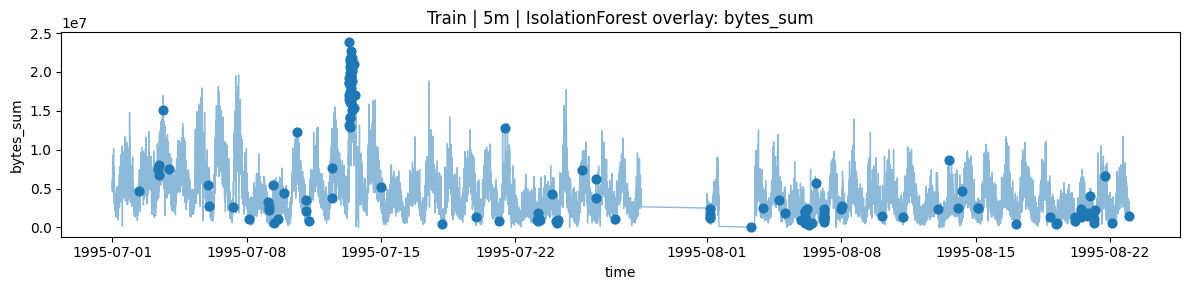

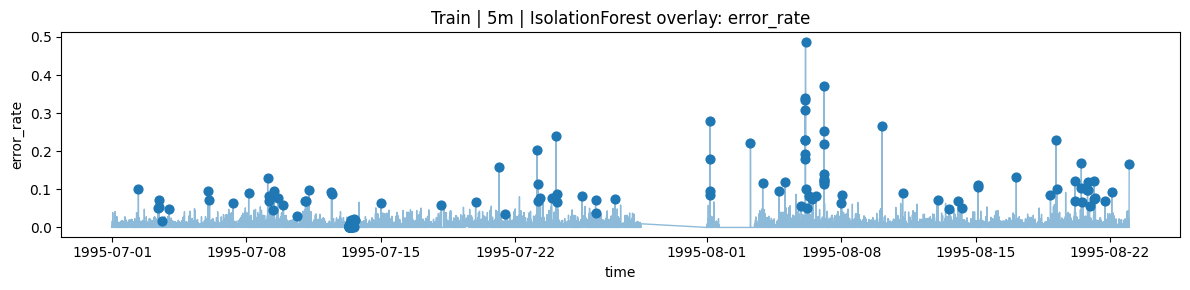


Tail drift (train vs test):
            metric    train_p95    train_p99    train_max     test_p95     test_p99     test_max
             hits     456.0000 6.127900e+02 1.501000e+03     445.0000     531.0000 6.550000e+02
        bytes_sum 9658672.8000 1.411702e+07 2.390741e+07 7407254.7000 9671692.0900 1.213170e+07
       error_rate       0.0237 5.110000e-02 4.878000e-01       0.0330       0.0708 3.519000e-01
     unique_hosts      83.0000 1.170000e+02 3.590000e+02      76.0000      91.0900 1.050000e+02
avg_bytes_per_req   35207.2849 5.075416e+04 1.269716e+06   31720.6627   46077.4866 1.529970e+05


In [9]:
# CELL 04 — EDA compact (report-ordered) — judge-friendly paths
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# ---------
# Robust base dir (same logic as CELL 03)
# ---------
cwd = Path.cwd()
if "PROJECT_ROOT" in globals():
    nb_root = Path(PROJECT_ROOT)
    if not nb_root.exists():
        nb_root = cwd if cwd.name.lower() == "notebooks" else (cwd / "notebooks")
else:
    nb_root = cwd if cwd.name.lower() == "notebooks" else (cwd / "notebooks")

BASE_DIR = nb_root
DATA_DIR_PATH = Path(DATA_DIR) if "DATA_DIR" in globals() else (BASE_DIR / "data")
OUT_BASE = BASE_DIR / "outputs"

# Allow env override but keep relative-safe defaults
TRAIN_DIR = Path(os.environ.get("SAVE_TRAIN_DIR", str(DATA_DIR_PATH / "train")))
TEST_DIR  = Path(os.environ.get("SAVE_TEST_DIR",  str(DATA_DIR_PATH / "test")))
OUT_DIR   = Path(os.environ.get("OUT_DIR_04",     str(OUT_BASE / "02_eda")))
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("BASE_DIR :", BASE_DIR.resolve())
print("TRAIN_DIR:", TRAIN_DIR.resolve())
print("TEST_DIR :", TEST_DIR.resolve())
print("OUT_DIR  :", OUT_DIR.resolve())

FREQS = {"1m":"1min", "5m":"5min", "15m":"15min"}
MAIN_FREQ_KEY = os.environ.get("MAIN_FREQ_KEY", "5m")
MAIN_FREQ = FREQS[MAIN_FREQ_KEY]
bucket_min = int(pd.Timedelta(MAIN_FREQ).total_seconds() / 60)

def load_ts3(split, k):
    p = os.path.join(TRAIN_DIR if split=="train" else TEST_DIR, f"ts3_{k}.parquet")
    df = pd.read_parquet(p)
    df["bucket_start"] = pd.to_datetime(df["bucket_start"], utc=False)
    return df

def pct(s, p):
    return float(np.nanpercentile(pd.to_numeric(s, errors="coerce"), p))

def tail_row(ts3, label):
    x = ts3[ts3["is_gap"].astype(int)==0]
    return pd.DataFrame([{
        "label": label, "rows": len(x),
        "hits_mean": float(np.nanmean(x["hits"])), "hits_med": float(np.nanmedian(x["hits"])),
        "hits_p95": pct(x["hits"],95), "hits_p99": pct(x["hits"],99), "hits_max": float(np.nanmax(x["hits"])),
        "bytes_mean": float(np.nanmean(x["bytes_sum"])), "bytes_p95": pct(x["bytes_sum"],95),
        "bytes_p99": pct(x["bytes_sum"],99), "bytes_max": float(np.nanmax(x["bytes_sum"])),
        "err_mean": float(np.nanmean(x["error_rate"])), "err_p95": pct(x["error_rate"],95),
        "err_max": float(np.nanmax(x["error_rate"])),
        "hosts_mean": float(np.nanmean(x["unique_hosts"])), "hosts_p95": pct(x["unique_hosts"],95),
    }])

# ============================================================
# 1) OVERVIEW (MAIN train/test)
# ============================================================
tr0 = load_ts3("train", MAIN_FREQ_KEY); te0 = load_ts3("test", MAIN_FREQ_KEY)
tr = tr0[tr0["is_gap"].astype(int)==0].copy()
te = te0[te0["is_gap"].astype(int)==0].copy()

base_cols = ["hits","bytes_sum","avg_bytes_per_req","err_4xx","err_5xx","error_rate","unique_hosts"]
for df in (tr, te):
    for c in base_cols: df[c] = pd.to_numeric(df[c], errors="coerce")
    df["rate_4xx"] = np.where(df["hits"]>0, df["err_4xx"]/df["hits"], 0.0)
    df["rate_5xx"] = np.where(df["hits"]>0, df["err_5xx"]/df["hits"], 0.0)

print(f"MAIN_FREQ={MAIN_FREQ_KEY} ({MAIN_FREQ}) | bucket={bucket_min} min")
print(f"train: rows={len(tr0):,} after_filter={len(tr):,} range={tr.bucket_start.min()} -> {tr.bucket_start.max()}")
print(f"test : rows={len(te0):,} after_filter={len(te):,} range={te.bucket_start.min()} -> {te.bucket_start.max()}")

# ============================================================
# 2) TAIL-RISK (ALL FREQS)
# ============================================================
train_stats = pd.concat([tail_row(load_ts3("train",k), f"train_{k}") for k in FREQS], ignore_index=True)
test_stats  = pd.concat([tail_row(load_ts3("test", k), f"test_{k}")  for k in FREQS], ignore_index=True)
print("\nTRAIN tail-risk stats:\n", train_stats.to_string(index=False))
print("\nTEST  tail-risk stats:\n", test_stats.to_string(index=False))

# ============================================================
# 3) TREND + DISTRIBUTION (MAIN, TRAIN)
# ============================================================
plt.figure(figsize=(12,3)); plt.plot(tr["bucket_start"], tr["hits"], linewidth=1)
plt.title(f"Train | {MAIN_FREQ_KEY} | Hits per bucket"); plt.xlabel("time"); plt.ylabel("hits")
plt.tight_layout(); plt.show()

plt.figure(figsize=(12,3)); plt.plot(tr["bucket_start"], tr["bytes_sum"], linewidth=1)
plt.title(f"Train | {MAIN_FREQ_KEY} | Bytes sum per bucket"); plt.xlabel("time"); plt.ylabel("bytes_sum")
plt.tight_layout(); plt.show()

plt.figure(figsize=(12,3)); plt.hist(tr["hits"].dropna(), bins=80)
plt.title(f"Train | {MAIN_FREQ_KEY} | Distribution of hits per bucket"); plt.xlabel("hits"); plt.ylabel("count")
plt.tight_layout(); plt.show()

plt.figure(figsize=(12,3)); plt.hist(tr["bytes_sum"].dropna(), bins=80)
plt.title(f"Train | {MAIN_FREQ_KEY} | Distribution of bytes_sum per bucket"); plt.xlabel("bytes_sum"); plt.ylabel("count")
plt.tight_layout(); plt.show()

# ============================================================
# 4) SEASONALITY (MAIN, TRAIN) + ACF PEAKS 12h/24h
# ============================================================
tr["hour"] = tr["bucket_start"].dt.hour
tr["dow"]  = tr["bucket_start"].dt.dayofweek

heat = (tr.groupby(["dow","hour"])["hits"].mean().unstack("hour")
        .reindex(index=range(7), columns=range(24)).fillna(0))

plt.figure(figsize=(12,3)); plt.imshow(heat.values, aspect="auto", interpolation="nearest")
plt.title(f"Train | {MAIN_FREQ_KEY} | Mean hits heatmap (DOW x hour)")
plt.xlabel("hour"); plt.ylabel("day_of_week"); plt.colorbar(label="mean hits")
plt.tight_layout(); plt.show()

plt.figure(figsize=(12,3)); tr.groupby("hour")["hits"].mean().plot()
plt.title(f"Seasonality | Train | {MAIN_FREQ_KEY} | Mean hits by hour-of-day")
plt.xlabel("hour"); plt.ylabel("mean hits"); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,3)); tr.groupby("dow")["hits"].mean().plot()
plt.title(f"Seasonality | Train | {MAIN_FREQ_KEY} | Mean hits by day-of-week")
plt.xlabel("dow (0=Mon)"); plt.ylabel("mean hits"); plt.tight_layout(); plt.show()

def acf_at_lag(series, lag):
    s = pd.to_numeric(series, errors="coerce").fillna(0).astype(float).values
    s = s - s.mean()
    denom = np.dot(s,s) if np.dot(s,s)!=0 else 1.0
    return float(np.dot(s[:-lag], s[lag:]) / denom) if lag < len(s) else np.nan

lag_12h = int((12*60)/bucket_min)
lag_24h = int((24*60)/bucket_min)
print(f"\nACF peaks (hits) | 12h lag={lag_12h}: {round(acf_at_lag(tr['hits'], lag_12h),4)}"
      f" | 24h lag={lag_24h}: {round(acf_at_lag(tr['hits'], lag_24h),4)}")

# ============================================================
# 5) CORRELATION (HALF + VALUES)
# ============================================================
corr_cols = ["hits","bytes_sum","avg_bytes_per_req","unique_hosts","error_rate","rate_5xx"]
C = tr[corr_cols].corr(numeric_only=True).reindex(index=corr_cols, columns=corr_cols).values

mask = np.triu(np.ones_like(C, dtype=bool), k=1)
C_m = np.ma.array(C, mask=mask)
cmap = plt.cm.viridis.copy(); cmap.set_bad(color="white")

plt.figure(figsize=(12,3))
plt.imshow(C_m, aspect="auto", interpolation="nearest", vmin=-1, vmax=1, cmap=cmap)
plt.title(f"Train | {MAIN_FREQ_KEY} | Correlation (lower triangle)")
plt.xticks(np.arange(len(corr_cols)), corr_cols, rotation=30, ha="right")
plt.yticks(np.arange(len(corr_cols)), corr_cols)
plt.colorbar()
for i in range(C.shape[0]):
    for j in range(C.shape[1]):
        if not mask[i, j]:
            plt.text(j, i, f"{C[i,j]:.2f}", ha="center", va="center", fontsize=9)
plt.tight_layout(); plt.show()

# ============================================================
# 6) LAG + ACF (MAIN, TRAIN)
# ============================================================
LAGS = [1,2,3,6,12,24,36,48]
def lag_corr(df, col, lags):
    s = pd.to_numeric(df[col], errors="coerce").astype(float)
    return pd.DataFrame([{"metric": col, "lag": L, "corr": float(s.corr(s.shift(L)))} for L in lags])

lag_tbl = pd.concat([lag_corr(tr,"hits",LAGS), lag_corr(tr,"bytes_sum",LAGS)], ignore_index=True).round(4)

def plot_acf_simple(series, max_lag, title):
    s = pd.to_numeric(series, errors="coerce").astype(float).fillna(0).values
    s = s - s.mean()
    denom = np.dot(s, s)
    acf = [1.0]
    for k in range(1, max_lag+1):
        if denom == 0 or k >= len(s): acf.append(0.0)
        else: acf.append(float(np.dot(s[:-k], s[k:]) / denom))
    plt.figure(figsize=(12,3))
    plt.stem(range(max_lag+1), acf)
    plt.title(title); plt.xlabel(f"lag (bucket = {bucket_min} min)"); plt.ylabel("ACF")
    plt.tight_layout(); plt.show()

plot_acf_simple(tr["hits"], 60, f"ACF | Train | {MAIN_FREQ_KEY} | hits")
plot_acf_simple(tr["bytes_sum"], 60, f"ACF | Train | {MAIN_FREQ_KEY} | bytes_sum")

# ============================================================
# 7) SPIKE LABELING (COUNTS ONLY)
# ============================================================
x = tr.copy()
p99_hits  = np.nanpercentile(x["hits"], 99)
p99_bytes = np.nanpercentile(x["bytes_sum"], 99)
p99_err   = np.nanpercentile(x["error_rate"], 99)
p99_abpr  = np.nanpercentile(x["avg_bytes_per_req"], 99)

x["is_spike_hits"]  = (x["hits"] > p99_hits).astype(int)
x["is_spike_bytes"] = (x["bytes_sum"] > p99_bytes).astype(int)
x["is_spike_err"]   = (x["error_rate"] > p99_err).astype(int)

x["spike_type"] = "normal"
x.loc[x["is_spike_err"]==1, "spike_type"] = "error_incident"
x.loc[(x["is_spike_hits"]==1) & (x["unique_hosts"] > np.nanpercentile(x["unique_hosts"], 95)) & (x["is_spike_err"]==0), "spike_type"] = "flash_crowd"
x.loc[(x["is_spike_hits"]==1) & (x["unique_hosts"] <= np.nanpercentile(x["unique_hosts"], 50)) & (x["is_spike_err"]==0), "spike_type"] = "bot_crawler"
x.loc[(x["is_spike_bytes"]==1) & (x["hits"] <= np.nanpercentile(x["hits"], 75)) & (x["avg_bytes_per_req"] > p99_abpr), "spike_type"] = "bandwidth_spike"

print("\nSpike type counts (train):\n", x["spike_type"].value_counts().to_string())

# ============================================================
# 8) ANOMALY DETECTION (IsolationForest + overlays)
# ============================================================
X = tr.assign(hour=tr["bucket_start"].dt.hour, dow=tr["bucket_start"].dt.dayofweek)[
    ["hits","bytes_sum","avg_bytes_per_req","unique_hosts","error_rate","rate_4xx","rate_5xx","hour","dow"]
].fillna(0)

Xs = StandardScaler().fit_transform(X)
iso = IsolationForest(n_estimators=300, contamination=0.01, random_state=42, n_jobs=-1).fit(Xs)
score = -iso.score_samples(Xs)
thr = float(np.percentile(score, 99.0))

tr_if = tr.copy()
tr_if["if_score"] = score
tr_if["if_is_anomaly"] = (score >= thr).astype("int8")

anom_csv = os.path.join(OUT_DIR, "anomalies_isoforest_train.csv")
tr_if.loc[tr_if["if_is_anomaly"]==1, ["bucket_start","if_score","hits","bytes_sum","error_rate","unique_hosts","rate_4xx","rate_5xx"]] \
     .sort_values("if_score", ascending=False).to_csv(anom_csv, index=False)

print(f"\nIsolationForest | Train | {MAIN_FREQ_KEY}: anomalies={int(tr_if.if_is_anomaly.sum()):,} ({tr_if.if_is_anomaly.mean()*100:.2f}%)")
print("Saved:", anom_csv)

def overlay(col, title, ylabel):
    plt.figure(figsize=(12,3))
    plt.plot(tr_if["bucket_start"], tr_if[col], alpha=0.5, linewidth=1)
    a = tr_if[tr_if["if_is_anomaly"]==1]
    plt.scatter(a["bucket_start"], a[col], s=40)
    plt.title(title); plt.xlabel("time"); plt.ylabel(ylabel)
    plt.tight_layout(); plt.show()

overlay("hits",      f"Train | {MAIN_FREQ_KEY} | IsolationForest overlay: hits", "hits")
overlay("bytes_sum", f"Train | {MAIN_FREQ_KEY} | IsolationForest overlay: bytes_sum", "bytes_sum")
overlay("error_rate",f"Train | {MAIN_FREQ_KEY} | IsolationForest overlay: error_rate", "error_rate")

# ============================================================
# 9) DRIFT (TAIL TRAIN VS TEST)
# ============================================================
def drift_row(a, b, name):
    a = pd.to_numeric(a, errors="coerce"); b = pd.to_numeric(b, errors="coerce")
    return {"metric": name,
            "train_p95": pct(a,95), "train_p99": pct(a,99), "train_max": float(np.nanmax(a)),
            "test_p95":  pct(b,95), "test_p99":  pct(b,99), "test_max":  float(np.nanmax(b))}

drift = pd.DataFrame([
    drift_row(tr["hits"], te["hits"], "hits"),
    drift_row(tr["bytes_sum"], te["bytes_sum"], "bytes_sum"),
    drift_row(tr["error_rate"], te["error_rate"], "error_rate"),
    drift_row(tr["unique_hosts"], te["unique_hosts"], "unique_hosts"),
    drift_row(tr["avg_bytes_per_req"], te["avg_bytes_per_req"], "avg_bytes_per_req"),
]).round(4)

print("\nTail drift (train vs test):\n", drift.to_string(index=False))
